In [1]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS 495 DataScience Capstone Project


In [2]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# --- Configuration ---
full_data = True
vocab_limit = 40000
enc_max_len = 64
dec_max_len = 150
max_dec_input_length = dec_max_len - 1
embedding_dim = 128
units = 128
batch = 64
repeat = 20
patience = 20
custom_learning_rate = 5e-5
adam_optimizer = Adam(learning_rate=custom_learning_rate)
val_ratio = 0.2
min_delta = 0.01

In [4]:
# --- Load Dataset ---
train_df = pd.read_csv("prompt_synopsis_train.csv")
if not full_data:
    train_df = train_df.sample(n=1000, random_state=42).reset_index(drop=True)

# --- Clean Text ---
def clean_text(text):
    return text.lower().strip().replace('\n', ' ')

for col in ['prompt', 'synopsis']:
    train_df[col] = train_df[col].astype(str).apply(clean_text)

In [6]:
# --- Tokenizer ---
PAD_ID = 0
OOV_ID = 1
BOS_ID = 2
EOS_ID = 3
NUM_SPECIAL_TOKENS_RESERVED = 4
num_words_to_fit = vocab_limit - NUM_SPECIAL_TOKENS_RESERVED

tokenizer = Tokenizer(num_words=num_words_to_fit, oov_token='<OOV>', filters='')
tokenizer.fit_on_texts(train_df['prompt'].tolist() + train_df['synopsis'].tolist())

new_word_index = {
    "<PAD>": PAD_ID,
    "<OOV>": OOV_ID,
    "<BOS>": BOS_ID,
    "<EOS>": EOS_ID
}
new_index_word = {v: k for k, v in new_word_index.items()}
next_available_id = NUM_SPECIAL_TOKENS_RESERVED
content_words_assigned = 0

for word, original_id in sorted(tokenizer.word_index.items(), key=lambda item: item[1]):
    if word in new_word_index:
        continue
    if content_words_assigned < num_words_to_fit:
        new_word_index[word] = next_available_id
        new_index_word[next_available_id] = word
        next_available_id += 1
        content_words_assigned += 1
    else:
        break

tokenizer.word_index = new_word_index
tokenizer.index_word = new_index_word
vocab_size = vocab_limit

with open("tokenizer_RNN-GRU_40k.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [7]:
# --- Sequence Tokenization ---
input_seqs = tokenizer.texts_to_sequences(train_df['prompt'])
output_seqs = tokenizer.texts_to_sequences(train_df['synopsis'])

synopsis_token_ids_augmented = [[BOS_ID] + seq + [EOS_ID] for seq in output_seqs]
decoder_input_ids = [seq[:-1] for seq in synopsis_token_ids_augmented]
decoder_target_ids = [seq[1:] for seq in synopsis_token_ids_augmented]

padded_input = pad_sequences(input_seqs, maxlen=enc_max_len, padding='post', truncating='post', value=PAD_ID)
decoder_input_data = pad_sequences(decoder_input_ids, maxlen=max_dec_input_length, padding='post', truncating='post', value=PAD_ID)
decoder_target_data = pad_sequences(decoder_target_ids, maxlen=max_dec_input_length, padding='post', truncating='post', value=PAD_ID)
decoder_target_data = np.expand_dims(decoder_target_data, axis=-1)

In [8]:
# --- Train/Validation Split ---
X_train_encoder, X_val_encoder, X_train_decoder, X_val_decoder, y_train_target, y_val_target = train_test_split(
    padded_input, decoder_input_data, decoder_target_data, test_size=val_ratio, random_state=42
)

train_inputs = (X_train_encoder, X_train_decoder)
val_inputs = [X_val_encoder, X_val_decoder]

In [9]:
# --- GRU Model ---
encoder_inputs_gru = Input(shape=(enc_max_len,), name='encoder_input_gru')
encoder_embedding_gru = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs_gru)
encoder_gru = GRU(units, return_state=True, unroll=True, name='encoder_gru')
encoder_outputs_gru, state_h_gru = encoder_gru(encoder_embedding_gru)

decoder_inputs_gru = Input(shape=(max_dec_input_length,), name='decoder_input_gru')
decoder_embedding_gru = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs_gru)
decoder_gru = GRU(units, return_sequences=True, return_state=True, unroll=True, name='decoder_gru')
decoder_outputs_sequence_gru, _ = decoder_gru(decoder_embedding_gru, initial_state=[state_h_gru])
decoder_dense_gru = Dense(vocab_size, activation='softmax')
output_gru = decoder_dense_gru(decoder_outputs_sequence_gru)

model_gru = Model(inputs=[encoder_inputs_gru, decoder_inputs_gru], outputs=output_gru)
model_gru.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# --- Summary ---
print("RNN-GRU Model Summary (40k Vocab)")
model_gru.summary()

RNN-GRU Model Summary (40k Vocab)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_gru   │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_gru   │ (None, 149)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 128)   │  5,120,000 │ encoder_input_gr… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 64)        │          0 │ encoder_input_gr… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 149, 128)  │  5,120,000 │ decoder_input_gr… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_gru (GRU)   │ [(None, 128),     │     99,072 │ embedding[0][0],  │
│                     │ (None, 128)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_gru (GRU)   │ [(None, 149,      │     99,072 │ embedding_1[0][0… │
│                     │ 128), (None,      │            │ encoder_gru[0][1] │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 149,       │  5,160,000 │ decoder_gru[0][0] │
│                     │ 40000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,598,144 (59.50 MB)

 Trainable params: 15,598,144 (59.50 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# --- Callbacks ---
gru_model_path = "rnn_gru_model_40k.keras"
checkpoint_gru = ModelCheckpoint(gru_model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
earlystop_gru = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta, restore_best_weights=True, verbose=1)

In [13]:
# --- Training ---
history_gru = model_gru.fit(
    train_inputs,
    y_train_target,
    batch_size=batch,
    epochs=repeat,
    validation_data=(val_inputs, y_val_target),
    callbacks=[checkpoint_gru, earlystop_gru],
    verbose=1
)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.0303 - loss: 9.4604
Epoch 1: val_loss improved from inf to 7.38419, saving model to rnn_gru_model_40k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 275s 195ms/step - accuracy: 0.0303 - loss: 9.4590 - val_accuracy: 0.0372 - val_loss: 7.3842
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0373 - loss: 7.3652
Epoch 2: val_loss improved from 7.38419 to 7.35393, saving model to rnn_gru_model_40k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.0373 - loss: 7.3652 - val_accuracy: 0.0372 - val_loss: 7.3539
Epoch 3/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0372 - loss: 7.3516
Epoch 3: val_loss improved from 7.35393 to 7.35259, saving model to rnn_gru_model_40k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.0372 - loss: 7.3516 - val_accuracy: 0.0372 - val_loss: 7.3526
Epoch 4/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0373 - loss: 7.3421
Epoch 4: val_loss im

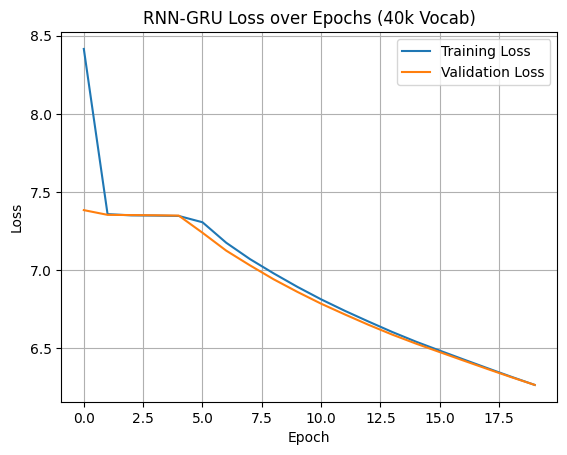

In [14]:
# --- Plot Loss ---
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('RNN-GRU Loss over Epochs (40k Vocab)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# --- Evaluation ---
model_gru.load_weights(gru_model_path)
val_loss_gru, val_accuracy_gru = model_gru.evaluate(val_inputs, y_val_target, verbose=0)
perplexity_gru = np.exp(val_loss_gru)
print(f"RNN-GRU Model Perplexity (40k Vocab): {perplexity_gru:.2f}")

RNN-GRU Model Perplexity (40k Vocab): 525.95
